In [324]:
import pandas as pd
import numpy as np
from __future__ import print_function, division
import pylab as pl
import geopandas as gpd
import requests
import os
import urllib.request
import zipfile
import sklearn.cluster
from sklearn import mixture
from PIL import Image
from scipy.misc import imread
from scipy.cluster.vq import kmeans2
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shape', 'imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### getting & preparing data

In [65]:
#download files from github and unzip

yr = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14']

for i in yr :
    url= 'https://github.com/fedhere/PUI2018_fb55/blob/master/HW12_fb55/zbp' + i + 'totals.zip?raw=true'

    urllib.request.urlretrieve(url, os.getenv('PUIDATA') + '/zbp' + i +'.zip')

    path= os.getenv('PUIDATA') + '/zbp' + i +'.zip'

    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(os.getenv('PUIDATA'))

In [113]:
#read files in and add onto one data frame, keeping only the # of establishments

df = pd.read_csv(os.getenv('PUIDATA') + '/zbp' + '94' + 'totals.txt')

df = df[['zip', 'est']]

yr2 = ['95', '96', '97', '98', '99', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14']

for i in yr2: 
    df_add = pd.read_csv(os.getenv('PUIDATA') + '/zbp' + i + 'totals.txt')
    
    df_add.columns = df_add.columns.str.lower()
    
    df_add = df_add[['zip', 'est']]
    
    df = df.join(df_add.set_index('zip'), on='zip', how='outer', rsuffix=i)
    

In [240]:
df.head()

,zip,est,est95,est96,est97,est98,est99,est00,est01,est02,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,1001,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,...,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0,458.0
1,1002,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,...,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0,560.0
2,1003,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,...,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0,18.0
3,1004,47.0,48.0,47.0,41.0,31.0,35.0,48.0,37.0,23.0,...,31.0,30.0,20.0,18.0,18.0,21.0,19.0,16.0,16.0,13.0
4,1005,92.0,95.0,101.0,104.0,95.0,82.0,86.0,90.0,94.0,...,94.0,98.0,106.0,97.0,87.0,96.0,91.0,94.0,97.0,97.0


In [294]:
#getting shapefile and dropping duplicates

url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
shape = gpd.read_file(url)

shape['ZIPCODE'] = pd.to_numeric(shape['ZIPCODE'])

shape = shape.drop_duplicates("ZIPCODE")

shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 248 entries, 0 to 262
Data columns (total 13 columns):
ZIPCODE       248 non-null int64
BLDGZIP       248 non-null object
PO_NAME       248 non-null object
POPULATION    248 non-null float64
AREA          248 non-null float64
STATE         248 non-null object
COUNTY        248 non-null object
ST_FIPS       248 non-null object
CTY_FIPS      248 non-null object
URL           248 non-null object
SHAPE_AREA    248 non-null float64
SHAPE_LEN     248 non-null float64
geometry      248 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 27.1+ KB


In [231]:
#shape.plot()
#shape.drop_duplicates("ZIPCODE").plot()
#shape
#print("ZIPCODES:",
    #  len(np.unique(shape.ZIPCODE)), "POLYGONS:",
     # len(shape.ZIPCODE),
    # "the difference is due to island with same zip as parts of land,",
     # "but disjoint shapes")
nyczips = shape.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

number of NYC zip codes: 248


In [236]:
shape_data = shape.merge(df, left_on='ZIPCODE', right_on='zip')

just_data = shape_data.drop(columns=['POPULATION', 'BLDGZIP', 'PO_NAME', 'AREA', 'STATE', "COUNTY", "ST_FIPS", 
                                     "CTY_FIPS", 'URL', 'SHAPE_AREA', 'SHAPE_LEN','geometry', 'zip'])

just_data = just_data.dropna(axis=0)

just_data.set_index('ZIPCODE', inplace=True)

just_data.head()

,est,est95,est96,est97,est98,est99,est00,est01,est02,est03,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


In [266]:
cdict = {}
columnlist = list(range(1994,2015))
for i in range(len(columnlist)):
    cdict[just_data.columns[i]] = columnlist[i]

just_data.rename(columns=cdict, inplace=True)    
just_data.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


### standardizing

In [276]:
just_data.shape


(230, 21)

In [277]:
vals = ((just_data.T - just_data.mean(1)) / just_data.std(1)).T

vals.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,0.087870,-0.117160,...,0.292900,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853
11213,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,-0.150580,0.060232,...,-0.058923,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875
11212,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,-0.212389,-0.164301,...,-0.092169,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464
11225,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,-0.184704,-0.089324,...,-0.057531,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007
11218,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,-0.357567,-0.270200,...,0.120649,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331


### creating clusters

In [278]:
#cluster with kmeans
km = KMeans(n_clusters=5, random_state=444).fit(vals)

In [279]:
#each observation in the km object has a label: #each ob 
#that is the cluster assigned to that observation
km.labels_.shape

(230,)

In [280]:
km.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 4, 3, 0, 0, 0, 2, 0, 0, 0, 0, 3,
       0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 3, 3, 0, 0, 0, 3, 0, 3, 3, 2, 3, 0, 3, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 1, 3, 3, 2, 0, 2, 0, 3, 0, 0, 3, 0,
       0, 3, 1, 2, 0, 0, 1, 0, 1, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 3, 4, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 3, 0, 3, 0, 4, 0, 0, 0, 0, 3,
       0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 4,
       4, 1, 0, 1, 1, 3, 0, 0, 2, 1, 4, 4, 1, 1, 2, 3, 1, 2, 1, 0, 1, 1,
       0, 4, 1, 0, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 4, 4, 3, 4, 2, 4, 2, 2,
       2, 1, 3, 3, 0, 2, 2, 4, 2, 3], dtype=int32)

In [281]:
#add column with cluster labels 

vals['cluster'] = km.labels_

In [282]:
vals = pd.DataFrame(vals)

vals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230 entries, 11436 to 10119
Data columns (total 22 columns):
1994       230 non-null float64
1995       230 non-null float64
1996       230 non-null float64
1997       230 non-null float64
1998       230 non-null float64
1999       230 non-null float64
2000       230 non-null float64
2001       230 non-null float64
2002       230 non-null float64
2003       230 non-null float64
2004       230 non-null float64
2005       230 non-null float64
2006       230 non-null float64
2007       230 non-null float64
2008       230 non-null float64
2009       230 non-null float64
2010       230 non-null float64
2011       230 non-null float64
2012       230 non-null float64
2013       230 non-null float64
2014       230 non-null float64
cluster    230 non-null int32
dtypes: float64(21), int32(1)
memory usage: 40.4 KB


### plotting cluster centers and time series

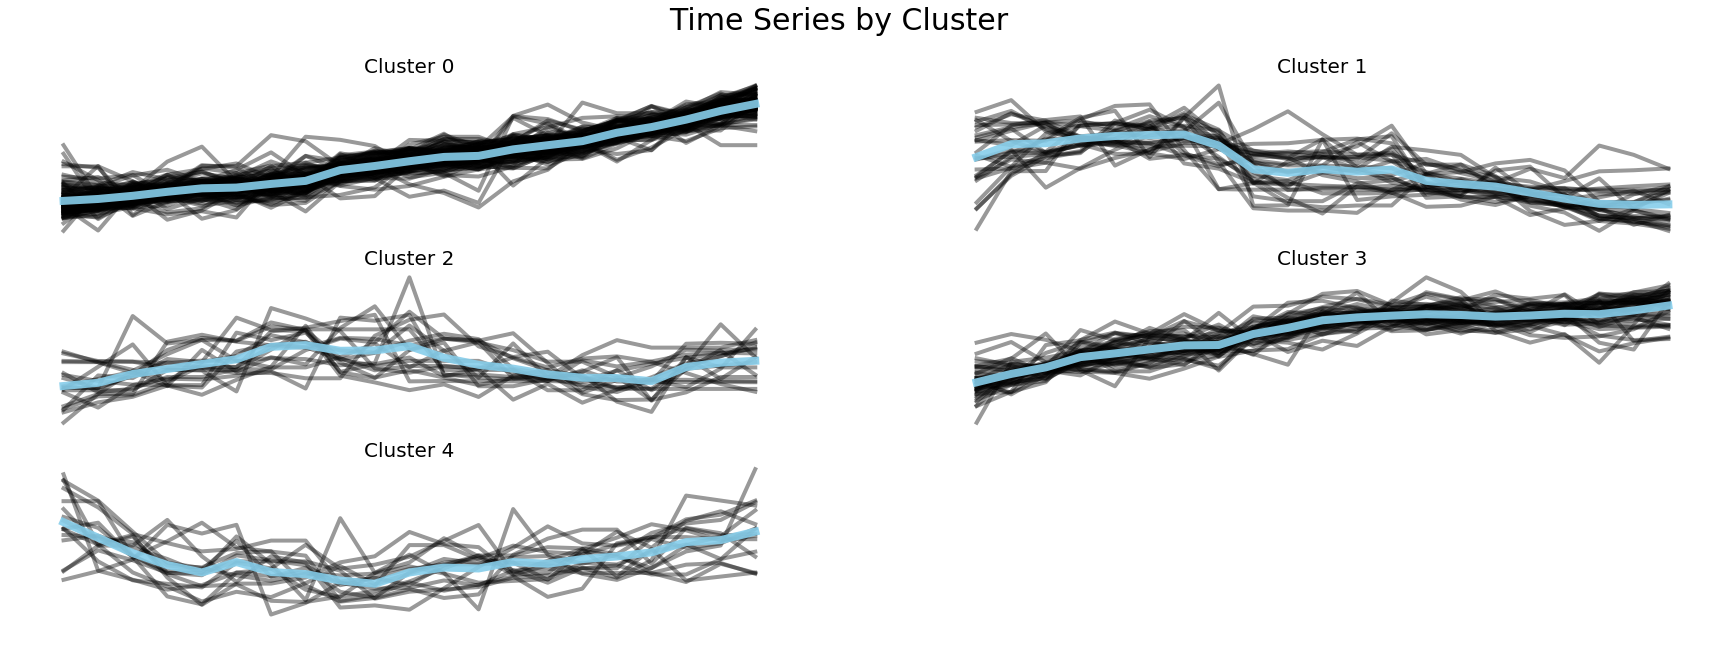

In [292]:
#plot all the timeseries in each cluster in a for loop (got help from Linda J. on this)

plt.figure(figsize=(30,10))
plt.suptitle('Time Series by Cluster', fontsize=30)
N=320
for x in range(5):
    N+=1
    plt.subplot(N)
    seg = vals[vals.cluster == x]
    for i in range(len(seg)):
        plt.plot(range(1994,2015), seg.iloc[i][0:-1], c='k', alpha=0.4, lw=4)
    plt.plot(range(1994,2015), seg.mean()[0:-1], c='skyblue', alpha=0.9, lw=8)
    plt.axis('off')
    plt.title('Cluster {}'.format(x), fontsize=20)

#### figure 1: 
All the time series in each cluster plotted by cluster. Blue line plots the mean of the time series for the cluster. We can see that zipcodes in some clusters (0 and 3) have been growing on average over the 1994 - 2014 time frame. Zipcodes in cluster 1 appear to have declined in number of businesses over the time frame. 

In [296]:
nyc_map = shape.merge(vals[['cluster']], left_on='ZIPCODE', right_index=True, how='left')

In [316]:
nyc_map.dropna(subset=['cluster'])

nyc_map.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,cluster
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",0.0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",0.0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",0.0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",0.0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",0.0


In [ ]:
nan_rows = df[df['name column'].isnull()]

/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


Text(0.5,1,'NYC Zip Codes Clustered by # of Businesses')

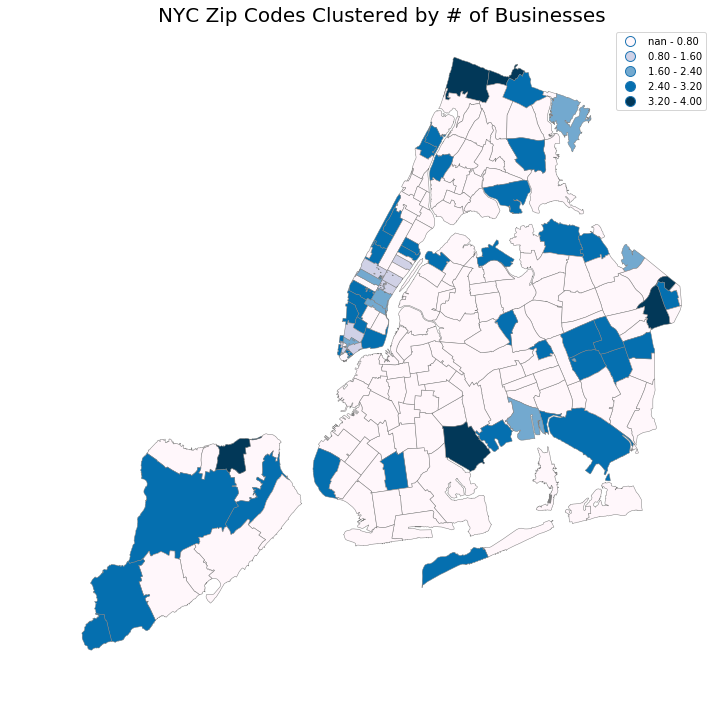

In [319]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

nyc_map.plot(column='cluster', cmap='PuBu', ax=ax, legend=True, 
                scheme='equal_interval' , k=5, edgecolor='grey', lw=0.5)
plt.axis('off')
plt.title('NYC Zip Codes Clustered by # of Businesses', fontsize=20)

#### figure 2: 
Cloropleth of NYC zip codes by 5 k-means clusters. The cluster data column is actually categorical, so the legend is not really meaningful. For instance in the legend where it says .80 - 1.60, that really means cluster '1'. Zipcodes in each cluster have some sort of similarity to one another in number of businesses. 

## now agglomerative clustering

In [320]:
vals2 = vals.drop(columns='cluster')

In [340]:
agc = AgglomerativeClustering(n_clusters=5,linkage='average').fit(vals2)
labelsaq = agc.labels_
centroidsag = np.zeros((5, vals2.shape[1]))

In [342]:
agc.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 3, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 4, 0, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 3, 3, 4,
       2, 3, 2, 3, 3, 2, 2, 2, 0, 3, 4, 1, 3, 3, 0, 2, 3, 4, 3, 2, 3, 3,
       2, 2, 4, 2, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 2, 2, 4, 0, 0,
       0, 3, 2, 2, 2, 0, 0, 2, 0, 2])

In [343]:
vals2['agc_cluster'] = agc.labels_

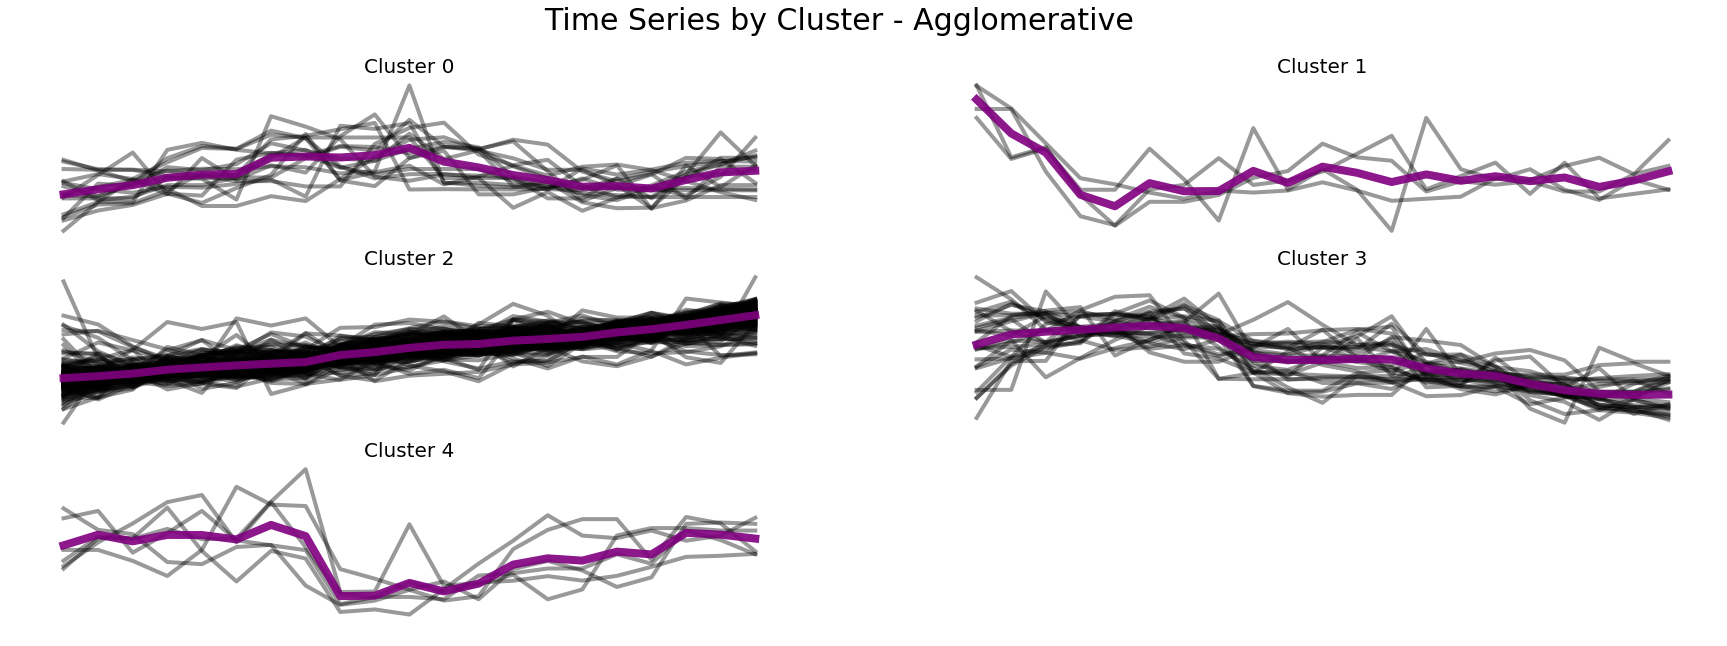

In [352]:
#plot all the timeseries in each cluster in a for loop (got help from Linda J. on this)

plt.figure(figsize=(30,10))
plt.suptitle('Time Series by Cluster - Agglomerative', fontsize=30)
N=320
for x in range(5):
    N+=1
    plt.subplot(N)
    seg = vals2[vals2.agc_cluster == x]
    for i in range(len(seg)):
        plt.plot(range(1994,2015), seg.iloc[i][0:-1], c='k', alpha=0.4, lw=4)
    plt.plot(range(1994,2015), seg.mean()[0:-1], c='purple', alpha=0.9, lw=8)
    plt.axis('off')
    plt.title('Cluster {}'.format(x), fontsize=20)

#### figure 3: 

Time series and mean line (in purple) for 5 agglomerative clusters. The Agglomerative clustering method gave us different results. Clusters 1 and 4 have very few zipcodes in them. Cluster 2 has by far the most zipcodes. 

COMPARISON: This gives us less variation than the k-means method. 

The clusters with the most easily identifiable trends are 2 and 3, with 2 trending upwar and 3 downward. 

In [347]:
nyc_map = nyc_map.merge(vals2[['agc_cluster']],left_on='ZIPCODE', right_index=True, how='left')

/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


Text(0.5,1,'NYC Zip Codes Clustered by # of Businesses')

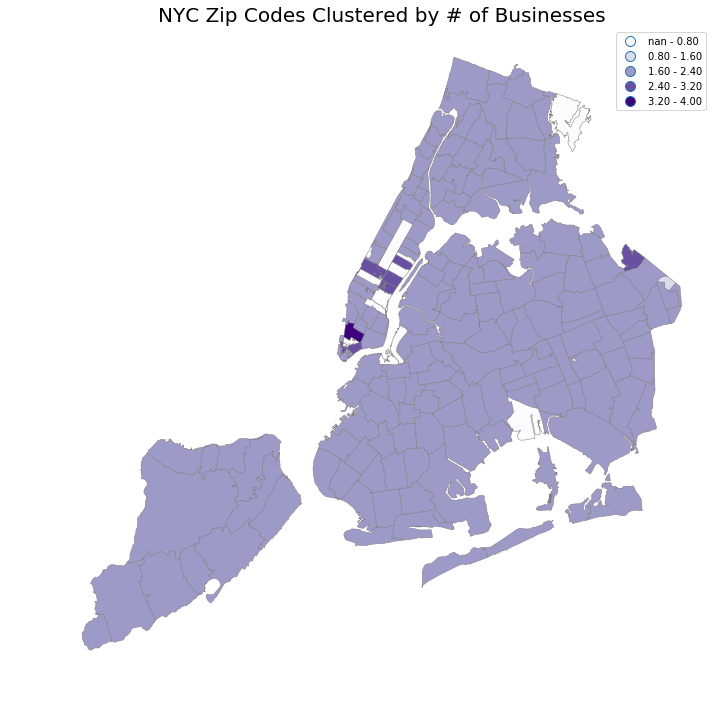

In [349]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

nyc_map.plot(column='agc_cluster', cmap='Purples', ax=ax, legend=True, 
                scheme='equal_interval' , k=5, edgecolor='grey', lw=0.5)
plt.axis('off')
plt.title('NYC Zip Codes Clustered by # of Businesses', fontsize=20)

### figure 4: 

Cloropleth of NYC with colors representing 5 agglomerative clusters by # of businesses over the time period 1994-2014. The cloropleth underlines further that most zipcodes are in cluster 2. This may not be the most useful way to look at this. 

### now a dendrogram

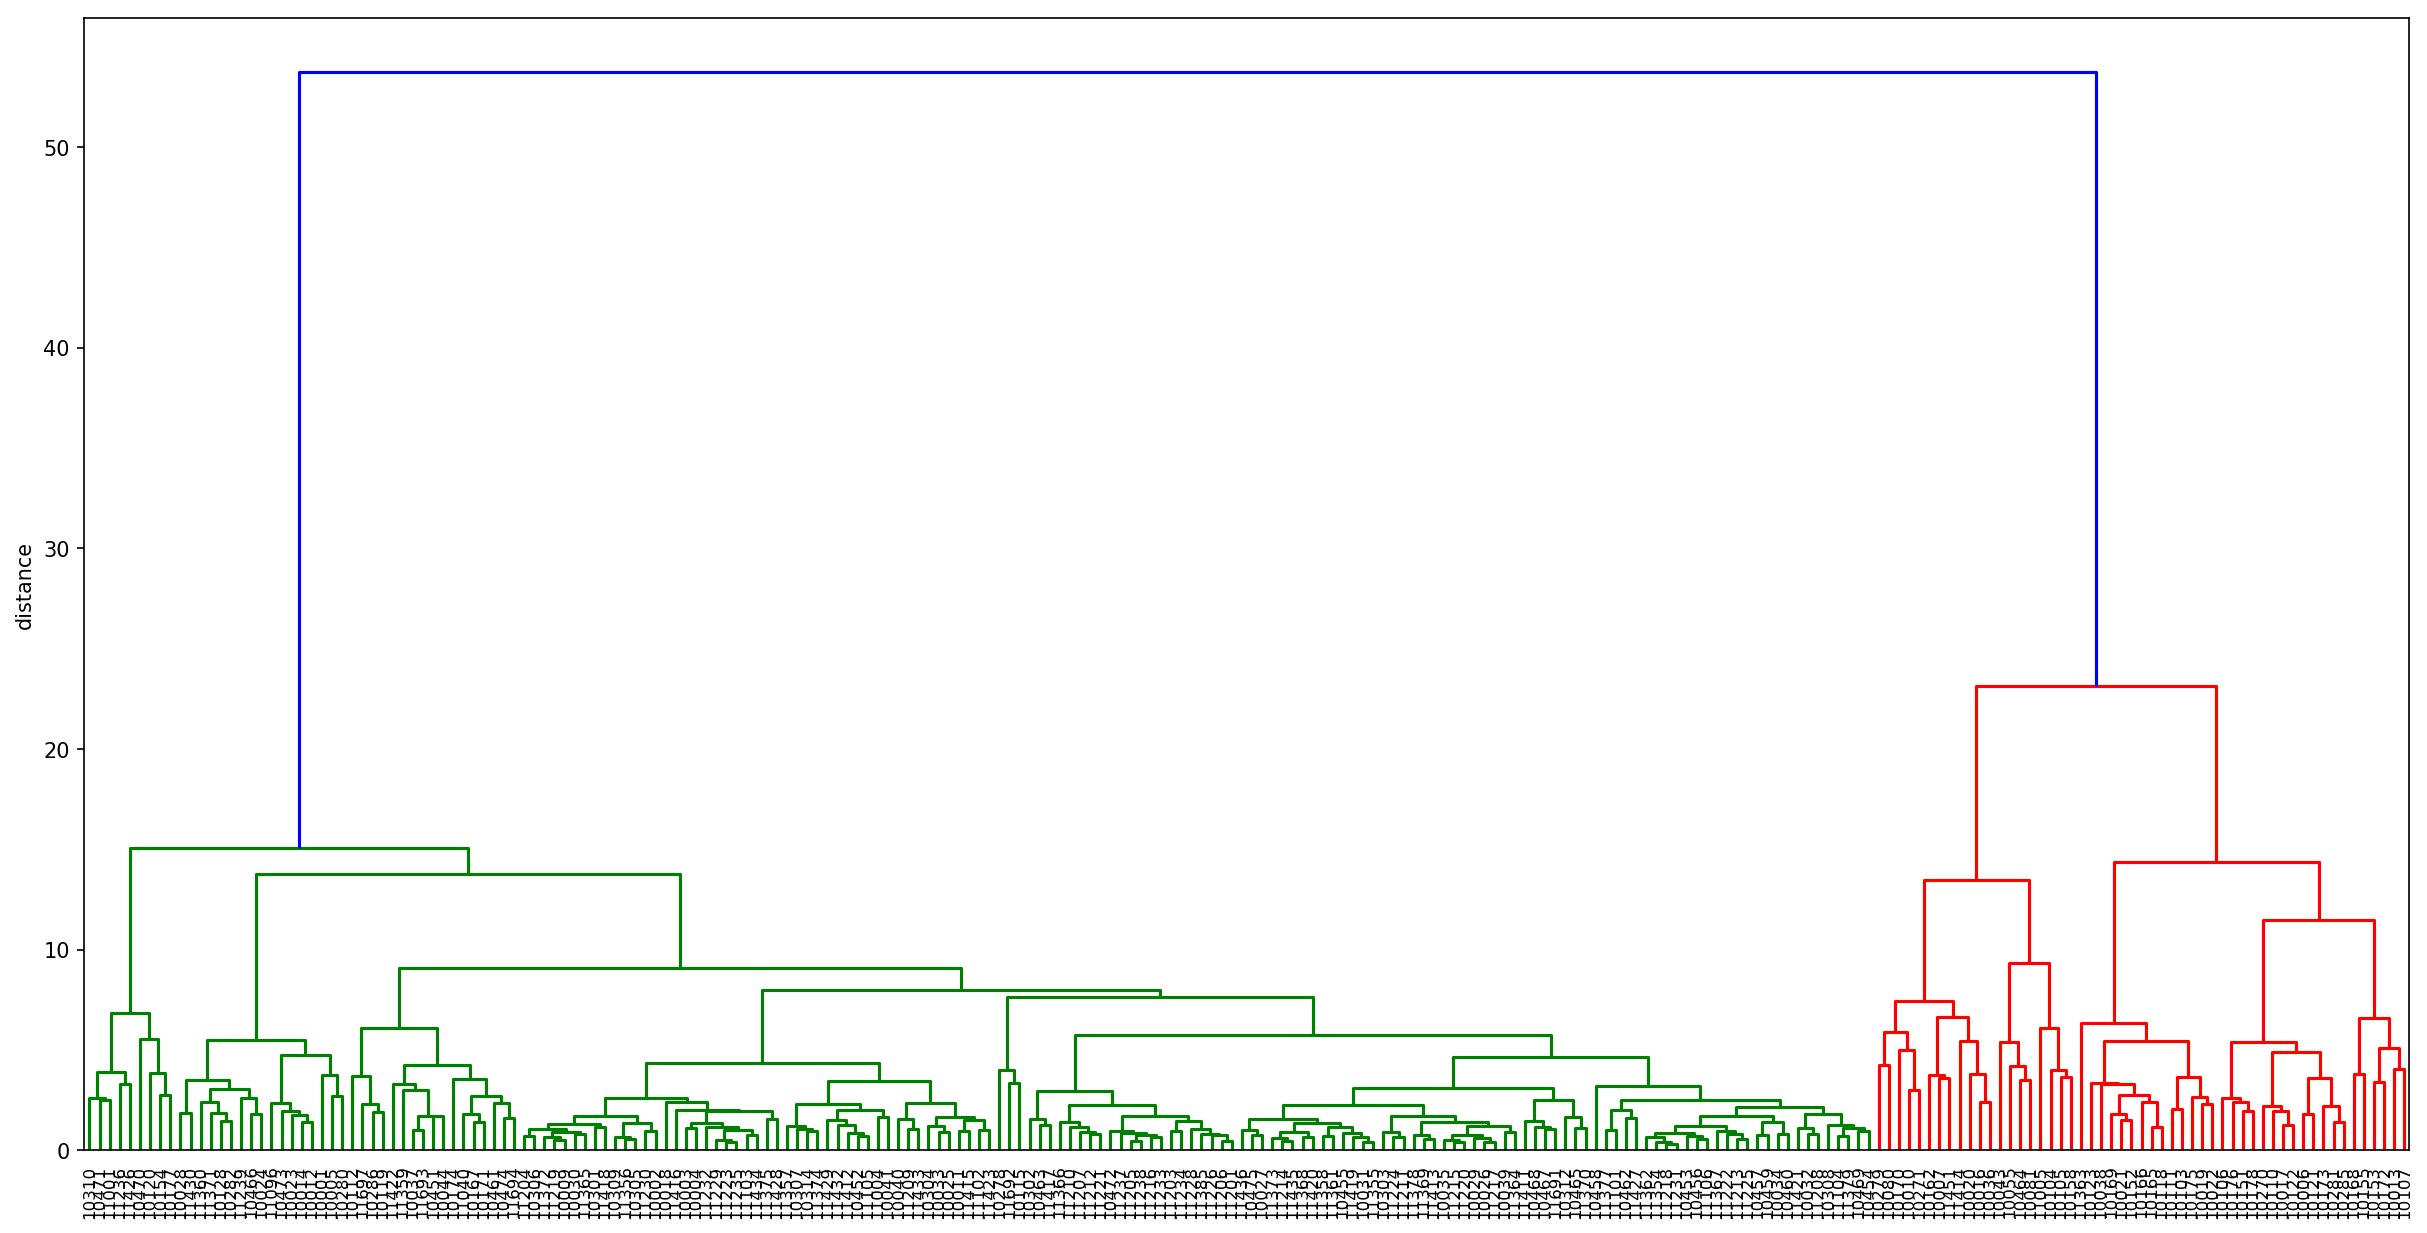

In [353]:
import scipy.cluster as scp
fig = pl.figure(figsize=(20,10), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals2, method='ward'),
                               labels = vals2.index,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels)

#### figure 5: 
Dendrogram of zipcodes clustered by # of businesses time series data over the time period 1994 - 2014. I'm not completely clear on how to best interpret this dendrogram, but it looks like this method only ends up with 2 clusters. 

## interpretation: 

The k-means clustering method seems to be more useful for this particular analysis. 

Wikapedia describes each cluster type this way: 

Agglomerative: This is a "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.

k-means: This clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. 

It seems like the "bottom-up" approach was too limiting. 

I want to be careful interpretimg what the clustering results mean. I think that clusters represent zip codes that have a similar # of businesses over the time or have similar trends in # of businesses over that time.  